In [1]:
# imports
import pandas as pd
import os
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
# read all storage folders to extract training info, i.e. markets and save it to envs
#TODO normalize rewards to "reward_summary"
df_keys = ["reward_summary", "mean_grid_coloration_percentage", "mean_num_reset_fields", "fully_colored", "mean_num_frames_per_episode", "mean_trades"]

try:
    training_folders = os.listdir('.') 
except(FileNotFoundError):
    training_folders = []

# while iterating create a wideform dataframe of all csv files
df_settings_dict = {}

for folder in training_folders:
    # if "plot_results" in folder or "dqn_comparisons" in folder:
    #     continue

    # read csv file (if it exists)
    try:
        df_settings_dict[folder] = pd.read_csv('./'+folder+'/log.csv')
    except:
        continue
    
    # only extract columns that are substrings of df_keys (only those are of interest here) 
    cols_of_interest = [col for col in df_settings_dict[folder].columns if any(df_key in col for df_key in df_keys) or "frames" in col or "reward" in col]
    df_settings_dict[folder] = df_settings_dict[folder].filter(items = cols_of_interest)  
    # add setting to the df columns
    df_settings_dict[folder].columns = [folder + "_" + str(col) for col in df_settings_dict[folder].columns if any(df_key in col for df_key in df_keys) or "frames" in col or "reward" in col]
    
# join all dataframes (one per setting)
all_data_df = pd.concat([df for df in df_settings_dict.values()], axis=1)

In [3]:
# Plot functions

def beautify_legend(plot_name, key):
    # beatify plot legend labels
    _, labels = plot_name.get_legend_handles_labels()
    for index, label in enumerate(labels):
        # if "-dr" in label:
        #     new_label = "difference reward"
        # else:
        new_label = label.split(key)[0]
        new_label = " ".join(new_label.split("_"))
        new_label = " ".join(new_label.split("-"))
        labels[index] = new_label.strip()
    plot_name.legend(handles=plot_name.legend_.legendHandles,labels=labels)

def normalize_rewards(setting_names):
    df = all_data_df.copy()
    for setting in setting_names:
        reward_cols = [col for col in df.columns if setting == col.split("_")[0] and "mean_reward" in col]
        # normalize reward values!
        new_col = setting+"_reward_summary"
        df[new_col] = df[reward_cols].sum(axis='columns')
        col_min = df[new_col].min()
        col_max = df[new_col].max()
        df[new_col] = (df[new_col]-col_min)/(col_max-col_min)
    return df

def recalculate_rewards(setting_names):
    df = all_data_df.copy()
    for setting in setting_names:
        reward_cols = [col for col in df.columns if setting == col.split("_")[0] and "mean_reward" in col]
        new_col = setting+"_reward_summary"
        if "mixed" in setting:
            df[new_col] = df[reward_cols].round(2).sum(axis='columns').round(2)
        else: # coop has always the same reward across agents
            df[new_col] = df[reward_cols].max(axis=1).round(2)
    return df

def form_data(df, stats_setting_names, key):
    frames_col = [col for col in df.columns if any(setting == col.split("_")[0] for setting in stats_setting_names) and "frames" in col][0]
    data = df[[col for col in df.columns if frames_col == col or any(setting == col.split("_")[0] for setting in stats_setting_names) and key in col]]
    long_data = data.melt(id_vars=[frames_col], var_name="setting")
    long_data.rename(columns={frames_col:'frames'}, inplace=True)
    long_data = long_data[long_data['setting'].str.contains(key, na = False)]
    return long_data

def improve_plot(plot, subplot, key, label, title, min_value=0, max_value=None, label_interval=None):
     # beatify plot legend labels
    beautify_legend(plot, key)

    subplot.set_ylabel(label)
    subplot.set_title(title, fontsize = 15.0)

    # show every label_interval x label if set
    if label_interval:
        [x_label.set_visible(False) for (index,x_label) in enumerate(plot.xaxis.get_ticklabels()) if index % label_interval != 0]
    
    # add some space to top/bottom of last y values 
    space = 0.05 if max_value < 10 else 1

    # set min/max values to be equal for better comparisons 
    if min_value < 0:
        plot.set_ylim(bottom=min_value-space)
    else:
        plot.set_ylim(bottom=-space)
        
    if "reward" in key:
        plot.set_ylim(top=1.2)
    elif "grid_coloration" in key:
        plot.set_ylim(top=1.05)
    elif not "trade" in label:
        plot.set_ylim(top=max_value+space)

def create_double_multiplot (top_stats_settings, top_plot_title, worst_stats_settings, worst_plot_title):
    top_df = recalculate_rewards(top_stats_settings)
    worst_df = recalculate_rewards(worst_stats_settings)
    
    sns.set_theme()
    max_col = 4
    max_row = 4
    col = 0
    row = 0

    # every key is shown in one plot (rewards are shown in two as an exception)
    for key in df_keys:
        if row >= max_row or (row == 0 and col == 0): 
            row = 0
            fig = plt.figure(constrained_layout=True, figsize=(25, 23))
            grid = plt.GridSpec(max_row, max_col, hspace=0.3)

        y_label = " ".join(key.split("_"))

        top_data = form_data(top_df, top_stats_settings, key)
        worst_data = form_data(worst_df, worst_stats_settings, key)

        top_hue_order = [setting+"_"+key for setting in top_stats_settings]
        worst_hue_order = [setting+"_"+key for setting in worst_stats_settings]

        min_value = top_data["value"].min() if top_data["value"].min() <= worst_data["value"].min() else worst_data["value"].min()
        max_value = top_data["value"].max() if top_data["value"].max() >= worst_data["value"].max() else worst_data["value"].max()
        
        if "reward" in key:
            t_reward_subplot = fig.add_subplot(grid[row:1, 0:2])
            t_reward_plot = sns.barplot(data=top_data.iloc[::7, :], x="frames", y="value", hue="setting", hue_order=top_hue_order)
            improve_plot(t_reward_plot, t_reward_subplot, key, y_label, top_plot_title, min_value=min_value, max_value=max_value, label_interval=3)

            w_reward_subplot = fig.add_subplot(grid[row:1, 2:max_col])
            w_reward_plot = sns.barplot(data=worst_data.iloc[::7, :], x="frames", y="value", hue="setting", hue_order=worst_hue_order)
            improve_plot(w_reward_plot, w_reward_subplot, key, y_label, worst_plot_title, min_value=min_value, max_value=max_value, label_interval=3)

            row += 1
            col = 0

        t_subplot = fig.add_subplot(grid[row, col])
        t_plot = sns.lineplot(data=top_data, x="frames", legend="brief", y="value", hue_order=top_hue_order, hue="setting", linewidth=2) # style="setting"
        improve_plot(t_plot, t_subplot, key, y_label, y_label, min_value=min_value, max_value=max_value)
        
        w_subplot = fig.add_subplot(grid[row, col+2])
        w_plot = sns.lineplot(data=worst_data, x="frames", legend="brief", y="value", hue_order=worst_hue_order, hue="setting", linewidth=2) # style="setting"
        improve_plot(w_plot, w_subplot, key, y_label, y_label, min_value=min_value, max_value=max_value)

        col += 1

        if col >= 2:
            row += 1
            col = 0

def print_double_multiplot(stats):
    for index, (title, settings) in enumerate(stats.items()):
        if index % 2 != 0:
            # skip odds, since top and worst settings are compared side by side in one go in double plot
            continue
        worst_title = "Worst " + title.split(' ', 1)[1]
        create_double_multiplot(settings, title, stats[worst_title], worst_title)

In [4]:
# stats table functions

def get_all_stats(setting, keys, exclude):
    all_stats = {}
    for col in all_data_df.columns:
        if any(key in col for key in keys) and setting in col and not any(ignored_setting in col for ignored_setting in exclude):
            for key in keys:
                if key in col and setting in col:
                    stats_key = setting+"|"+key

                    if stats_key not in all_stats:
                        all_stats[stats_key] = {}
                    
                    if "grid_coloration" in key:
                        # calculate mean
                        all_stats[stats_key][col] = all_data_df[col].mean()
                    elif "reward" not in key:
                        all_stats[stats_key][col] = sum(all_data_df[col]) #sum(all_data_df[col][all_data_df[col].notna()])
    
    #  agent specific calculations
    if any("reward" in key for key in keys):
        #iterate all settings
        for training_folder in training_folders:
            if setting in training_folder and not any(ignored_setting in training_folder for ignored_setting in exclude):
                reward_cols = [col for col in all_data_df.columns if training_folder == col.split("_")[0] and "mean_reward" in col]
                col_name = reward_cols[0].split("_agent")[0]
                if "mixed" in training_folder:
                    all_stats[stats_key][col_name] = all_data_df[reward_cols].round(2).sum(axis='columns').mean()
                else: # coop has always the same reward across agents
                    all_stats[stats_key][col_name] = all_data_df[reward_cols].max(axis=1).mean()
    
    return all_stats

def get_top_worst_settings(keys, setting, stats_amount=10, exclude=[]):
    all_stats = get_all_stats(setting, keys, exclude)

    results = []
    table_headers = []
    df_cols = {}
    for stat, entries in all_stats.items():
        formatted_table_header = " ".join(stat.split("_")).split("|")[1]
        top_header = "Top " + formatted_table_header
        worst_header = "Worst " + formatted_table_header
        if top_header not in df_cols:
            df_cols[top_header] = [] 
        if worst_header not in df_cols:
            df_cols[worst_header] = [] 
            
        table_headers.append(top_header)
        table_headers.append(worst_header)
        # Top scores
        top_keys = sorted(entries, key=entries.get, reverse=True)[:stats_amount]
        results.append(top_keys)
        results.append([all_stats[stat][top_key] for top_key in top_keys])
        df_cols[top_header] = [top_key.split("_")[0] for top_key in top_keys]
        # Worst scores
        worst_keys = sorted(entries, key=entries.get, reverse=False)[:stats_amount]
        results.append(worst_keys)
        results.append([all_stats[stat][worst_key] for worst_key in worst_keys])
        df_cols[worst_header] = [worst_key.split("_")[0] for worst_key in worst_keys]

    return results, table_headers, df_cols

def get_stats(*args, print_table=False):
    stats, headers, df_cols = get_top_worst_settings(*args)

    stats_table = PrettyTable(['Position'] + headers)
    position = 1
    
    for row, _ in enumerate(stats[0]): # go through all entries
        row_entries = [position]
        # odd number contain values, even numbers contain settings
        # stats[1] contains values
        for column, stat in enumerate(stats):
            if column % 2 != 0:
                continue
            short_key = " ".join(stat[row].split("_")[0].split("-"))
            row_entries.append("{:0.1f}".format(stats[column+1][row])+" \n "+ short_key + " \n ")
        
        if row_entries:
            stats_table.add_row(row_entries)   
            position += 1
    
    if print_table:
        print(stats_table)
    
    return df_cols

In [5]:
# if nan values occur in stats table find out what setting might be the problem here
# print(all_data_df[all_data_df.columns[~all_data_df.isnull().any()]].columns)

# Stats Tables

## Top PPO Runs

In [6]:
_ = get_stats(["reward", "fully_colored"], "2-ppo", 5, print_table=True)

+----------+-------------------------------------------+--------------------------+-------------------------------------------+--------------------------+
| Position |             Top fully colored             |   Worst fully colored    |                 Top reward                |       Worst reward       |
+----------+-------------------------------------------+--------------------------+-------------------------------------------+--------------------------+
|    1     |                  2578.0                   |          41.0            |                    1.0                    |           0.5            |
|          |          2 ppo mixed competitive          |     2 ppo am no debt     |         2 ppo mixed competitive sm        |  2 ppo am goal no reset  |
|          |                                           |                          |                                           |                          |
|    2     |                  2525.0                   |          46.0

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


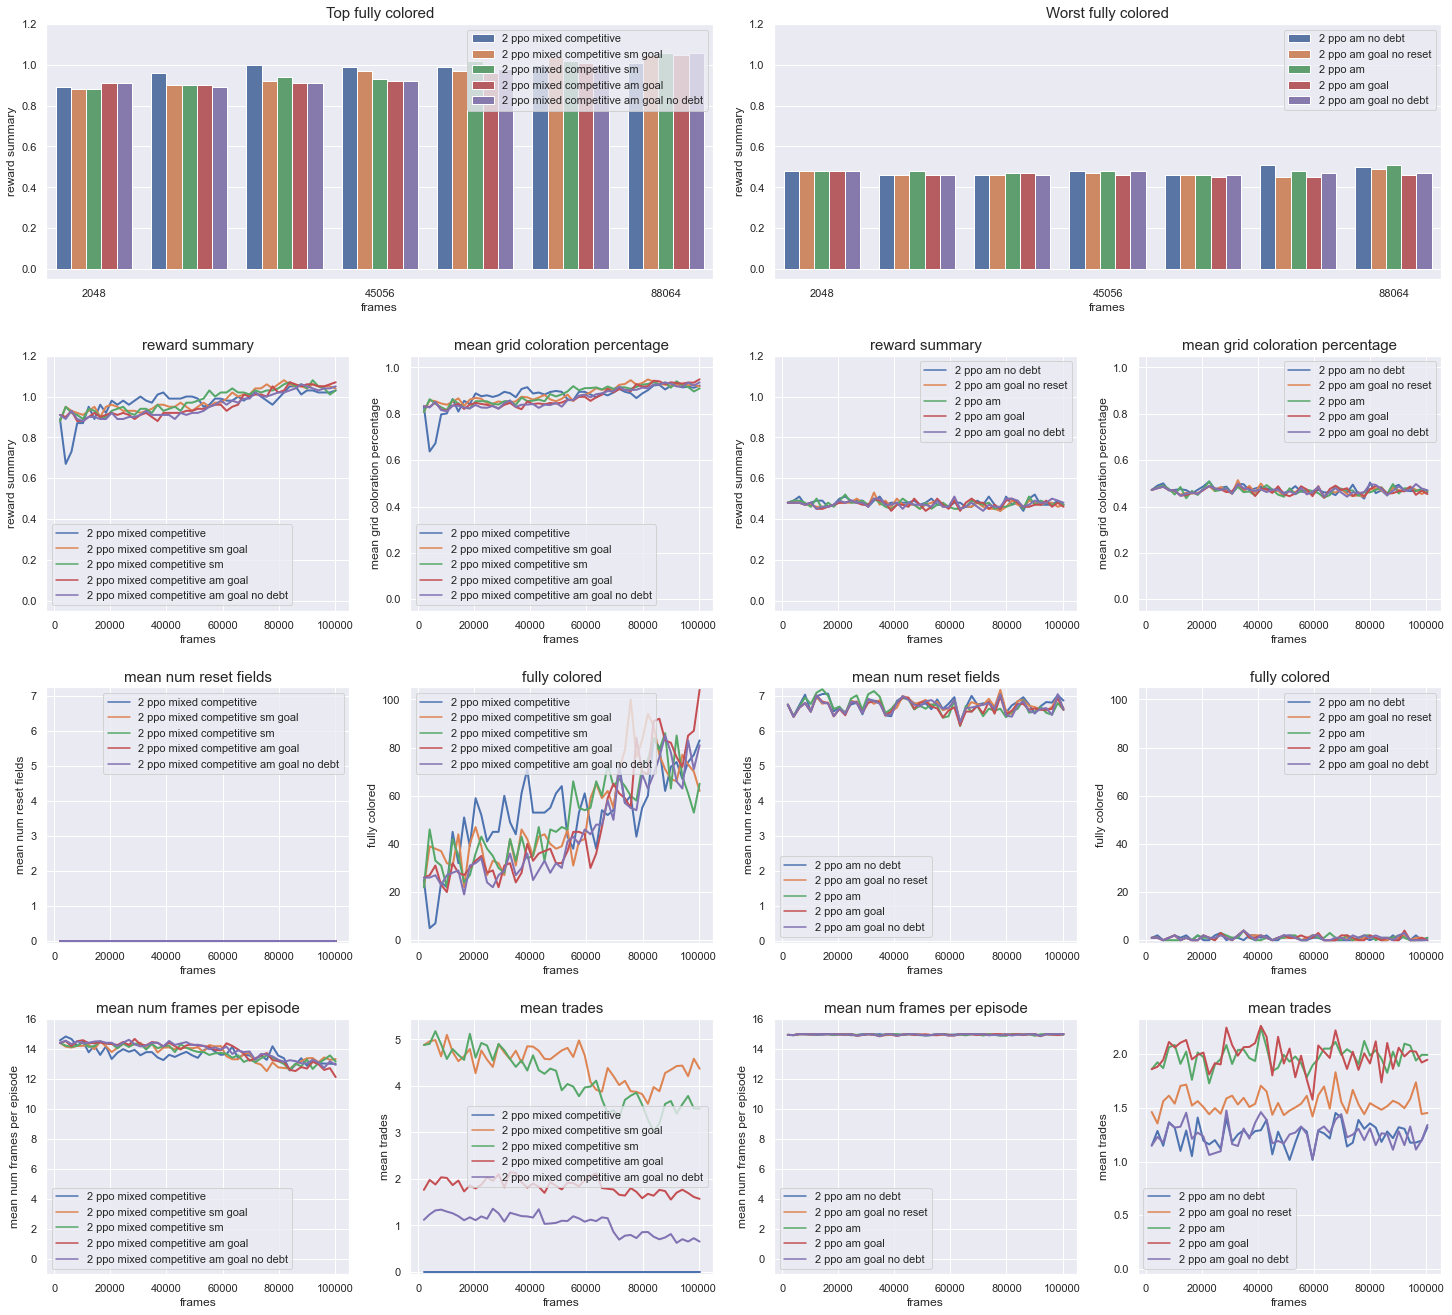

In [7]:
ppo_stats = get_stats(["fully_colored"], "2-ppo", 5)
print_double_multiplot(ppo_stats)

## Top PPO Runs with restrictions

In [8]:
# only cooperation
_ = get_stats(["reward", "fully_colored"], "2-ppo", 5, ["mixed", "competitive"], print_table=True)

+----------+--------------------------+--------------------------+---------------------+--------------------------+
| Position |    Top fully colored     |   Worst fully colored    |      Top reward     |       Worst reward       |
+----------+--------------------------+--------------------------+---------------------+--------------------------+
|    1     |          105.0           |          41.0            |         0.5         |           0.5            |
|          |         2 ppo dr         |     2 ppo am no debt     |       2 ppo sm      |  2 ppo am goal no reset  |
|          |                          |                          |                     |                          |
|    2     |          77.0            |          46.0            |         0.5         |           0.5            |
|          |          2 ppo           |  2 ppo am goal no reset  |  2 ppo sm no reset  |      2 ppo am goal       |
|          |                          |                          |      

In [9]:
# only mixed
_ = get_stats(["reward", "fully_colored"], "2-ppo-mixed", 5, ["competitive"], print_table=True)

+----------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+
| Position |       Top fully colored        |      Worst fully colored       |           Top reward           |          Worst reward          |
+----------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+
|    1     |            1659.0              |             145.0              |              0.7               |              0.5               |
|          |          2 ppo mixed           |    2 ppo mixed am no reset     |          2 ppo mixed           |    2 ppo mixed am no reset     |
|          |                                |                                |                                |                                |
|    2     |            1147.0              |             332.0              |              0.7               |              0.6  

In [10]:
# only competitive
_ = get_stats(["reward", "fully_colored"], "2-ppo-mixed-competitive", 5, [], print_table=True)

+----------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
| Position |             Top fully colored             |            Worst fully colored            |                 Top reward                |                Worst reward               |
+----------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
|    1     |                  2578.0                   |                  1746.0                   |                    1.0                    |                    0.9                    |
|          |          2 ppo mixed competitive          |         2 ppo mixed competitive am        |         2 ppo mixed competitive sm        |         2 ppo mixed competitive am        |
|          |                                           

In [11]:
# without competitive settings
_ = get_stats(["reward", "fully_colored"], "2-ppo", 5, ["competitive"], print_table=True)

+----------+--------------------------------+--------------------------+--------------------------------+--------------------------+
| Position |       Top fully colored        |   Worst fully colored    |           Top reward           |       Worst reward       |
+----------+--------------------------------+--------------------------+--------------------------------+--------------------------+
|    1     |            1659.0              |          41.0            |              0.7               |           0.5            |
|          |          2 ppo mixed           |     2 ppo am no debt     |          2 ppo mixed           |  2 ppo am goal no reset  |
|          |                                |                          |                                |                          |
|    2     |            1147.0              |          46.0            |              0.7               |           0.5            |
|          |      2 ppo mixed sm goal       |  2 ppo am goal no reset

In [12]:
# restricted_ppo_stats = get_stats(["fully_colored"], "2-ppo", 5, ["competitive"])
# print_double_multiplot(restricted_ppo_stats)

+----------+------------------------------+------------------------------+------------------------------+------------------------------+
| Position |      Top fully colored       |     Worst fully colored      |          Top reward          |         Worst reward         |
+----------+------------------------------+------------------------------+------------------------------+------------------------------+
|    1     |           2578.0             |            48.0              |             1.0              |             0.5              |
|          |   2 ppo mixed competitive    |           2 ppo am           |  2 ppo mixed competitive sm  |           2 ppo am           |
|          |                              |                              |                              |                              |
|    2     |           2476.0             |            56.0              |             1.0              |             0.5              |
|          |  2 ppo mixed competitive sm 

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


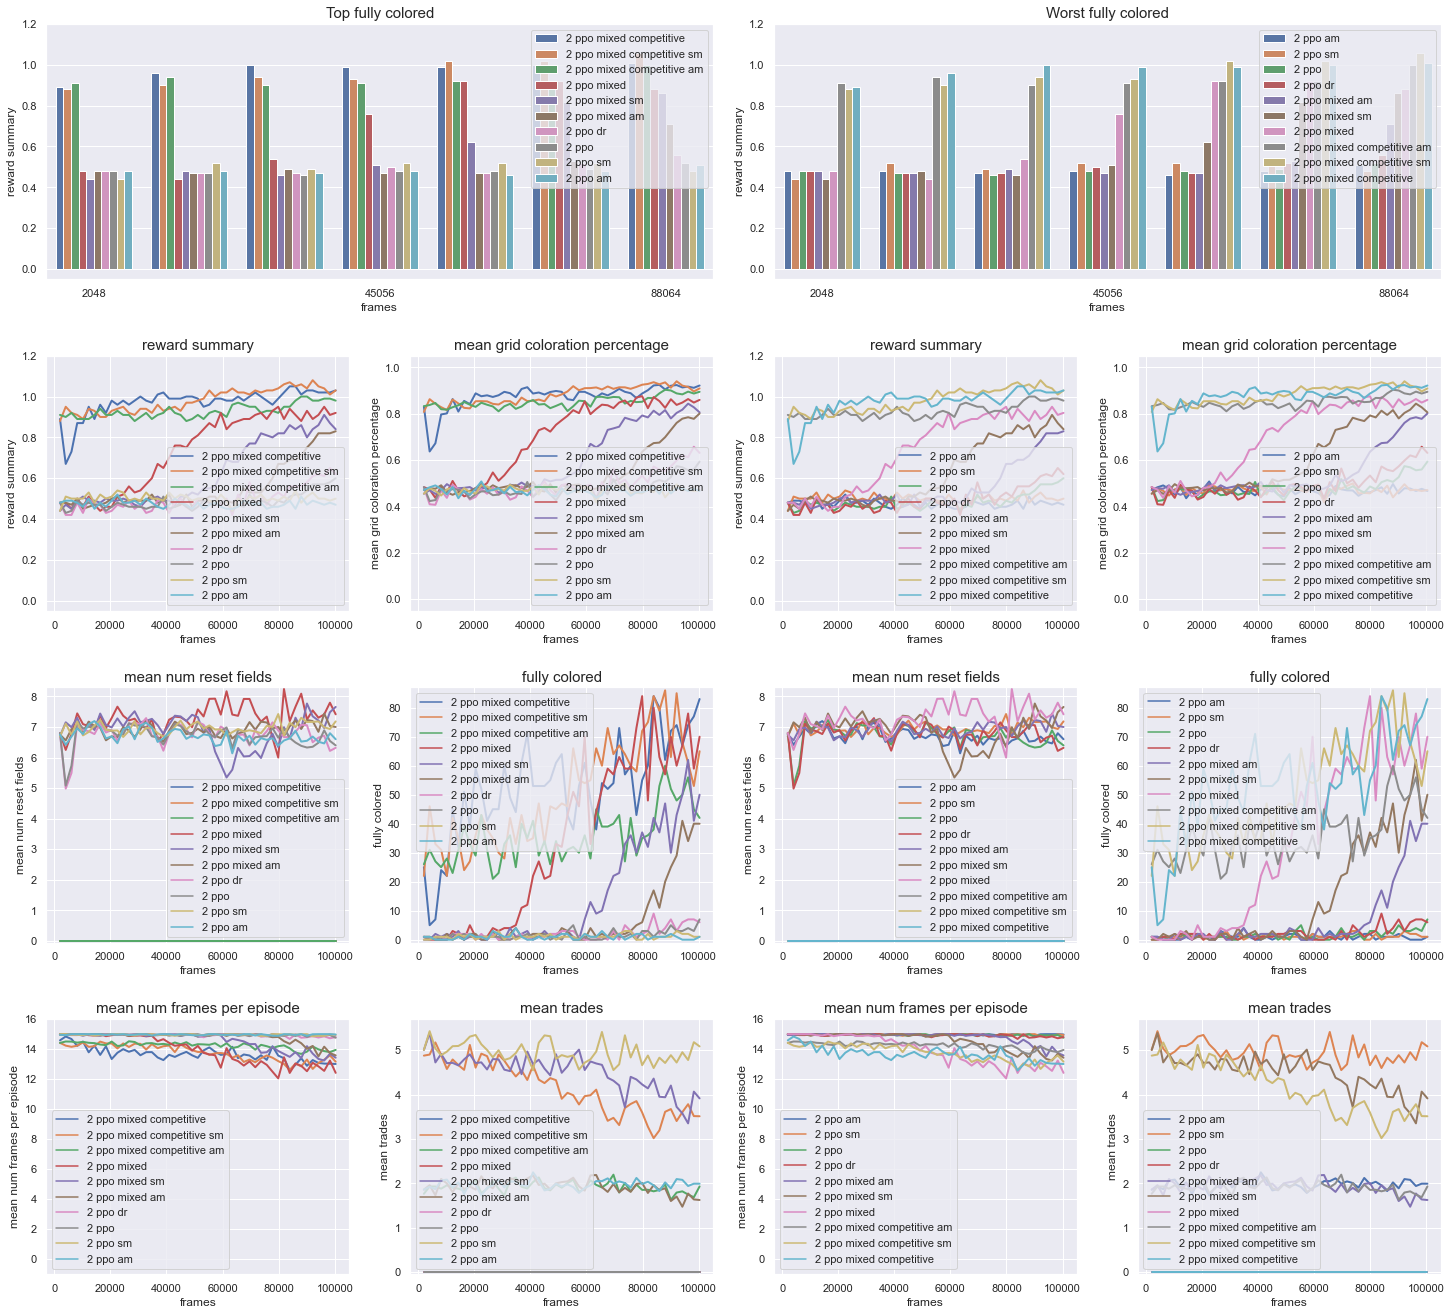

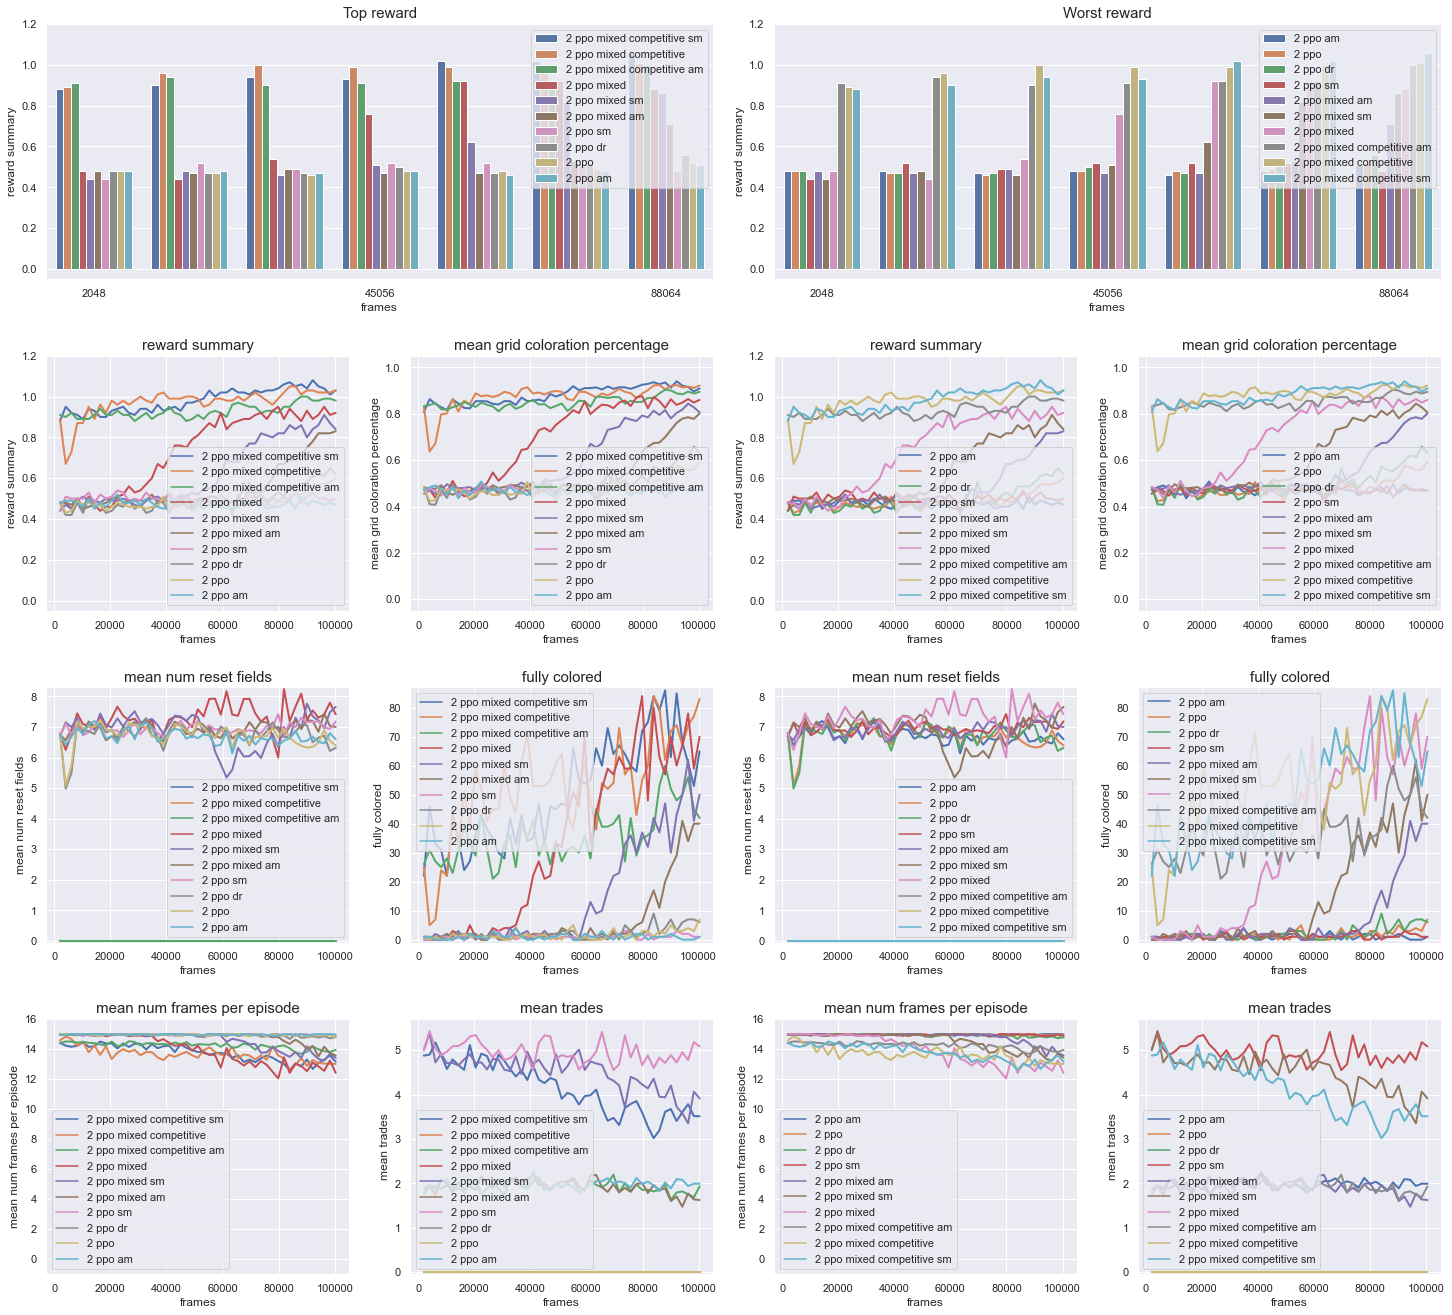

In [13]:
# without restrictive market settings (ignoring goal, no reset and no debt settings)

# pool of 10 settings remain:
# base settings: coop, mixed, competitive   -> + 3
# 2 markets: am, sm                         -> + 6 (for each base setting)
# and difference rewards                    -> + 1 = 10 
ppo_restictive_markets = get_stats(["reward", "fully_colored"], "2-ppo", 10, ["goal", "no-reset", "no-debt"], print_table=True)
print_double_multiplot(ppo_restictive_markets)

In [14]:
# plain_ppo_stats = get_stats(["fully_colored"], "2-ppo", 5, ["goal", "no-reset", "no-debt"])
# print_double_multiplot(plain_ppo_stats)

## Top DQN Runs

In [15]:
_ = get_stats(["reward", "fully_colored"], "2-dqn", 5, print_table=True)

+----------+--------------------------------------+---------------------+-------------------------------------------+-------------------------+
| Position |          Top fully colored           | Worst fully colored |                 Top reward                |       Worst reward      |
+----------+--------------------------------------+---------------------+-------------------------------------------+-------------------------+
|    1     |               9947.0                 |       2586.0        |                    1.1                    |           0.7           |
|          |      2 dqn mixed competitive sm      |       2 dqn dr      |         2 dqn mixed competitive am        |         2 dqn dr        |
|          |                                      |                     |                                           |                         |
|    2     |               9869.0                 |       2965.0        |                    1.1                    |           0.9     

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


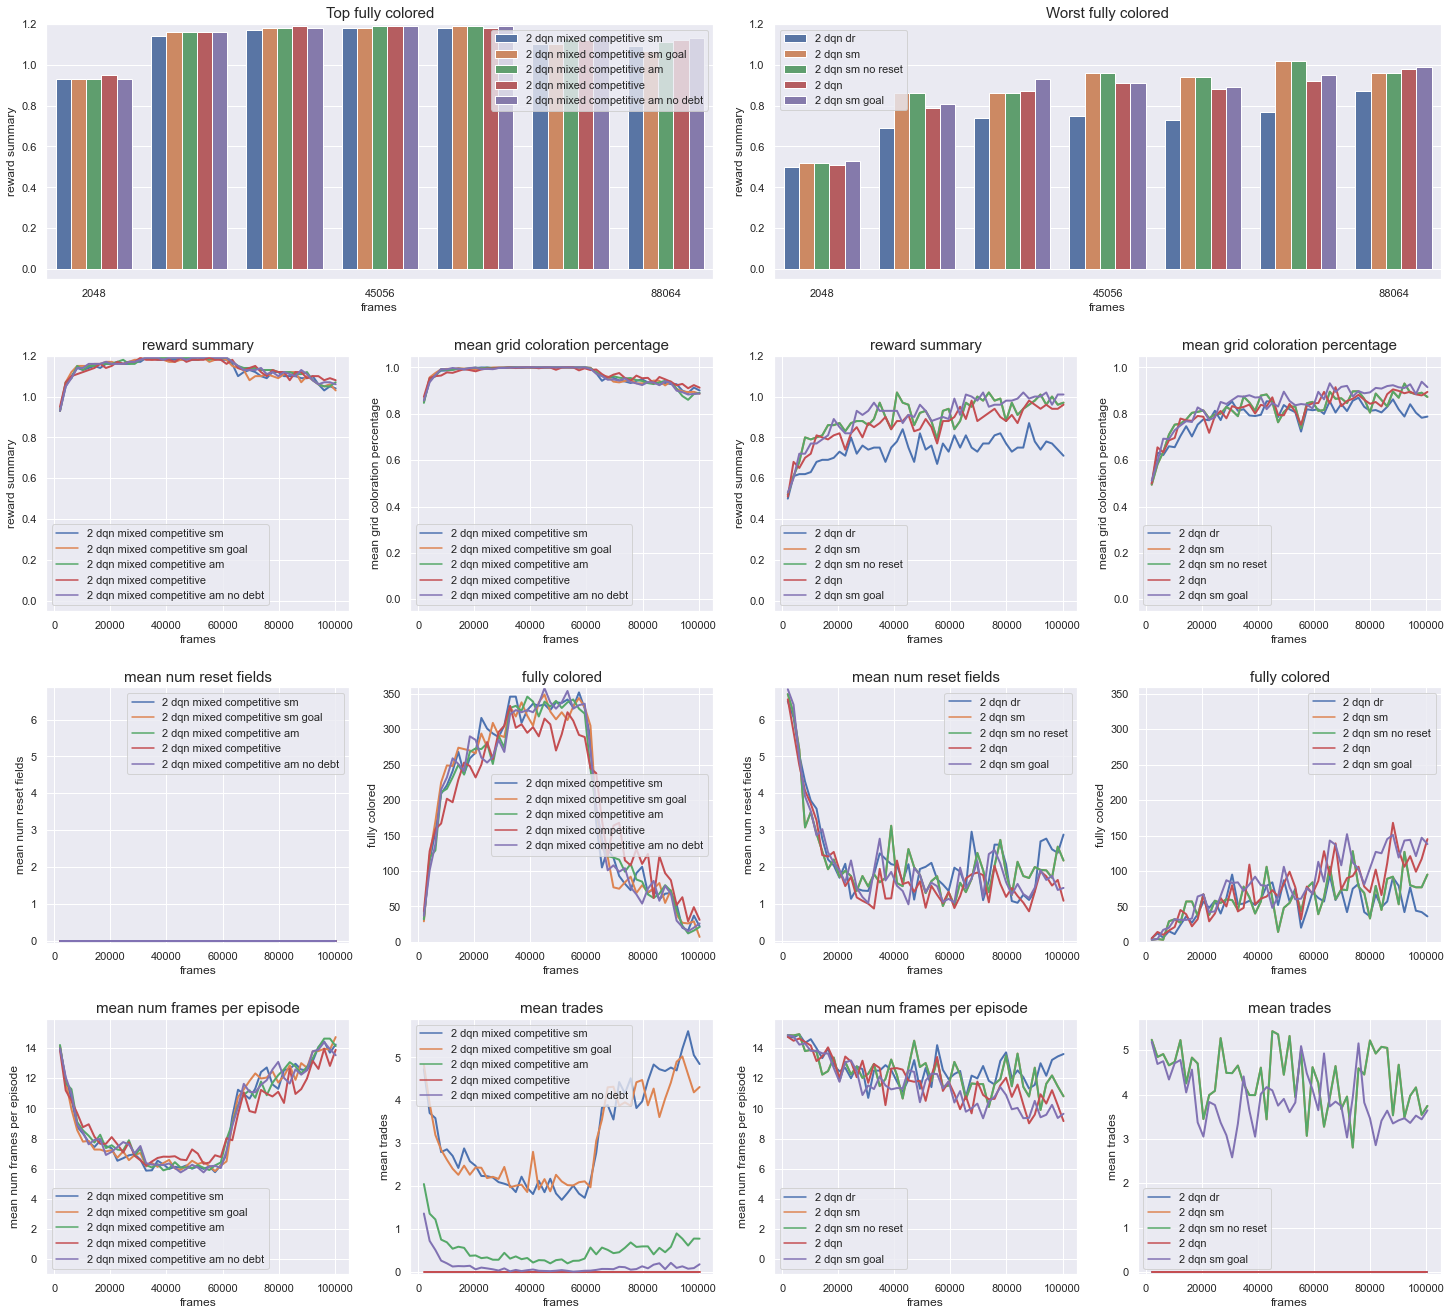

In [16]:
dqn_stats = get_stats(["fully_colored"], "2-dqn", 5)
print_double_multiplot(dqn_stats)

## Restricted DQN Runs

In [17]:
# only cooperation
_ = get_stats(["reward", "fully_colored"], "2-dqn", 5, ["mixed", "competitive"], print_table=True)

+----------+--------------------------+---------------------+--------------------------+-------------------------+
| Position |    Top fully colored     | Worst fully colored |        Top reward        |       Worst reward      |
+----------+--------------------------+---------------------+--------------------------+-------------------------+
|    1     |         4578.0           |       2586.0        |           0.9            |           0.7           |
|          |     2 dqn am no debt     |       2 dqn dr      |      2 dqn sm goal       |         2 dqn dr        |
|          |                          |                     |                          |                         |
|    2     |         4404.0           |       2965.0        |           0.9            |           0.9           |
|          |  2 dqn am goal no reset  |       2 dqn sm      |  2 dqn sm goal no reset  |          2 dqn          |
|          |                          |                     |                   

In [18]:
# only mixed
_ = get_stats(["reward", "fully_colored"], "2-dqn-mixed", 5, ["competitive"], print_table=True)

+----------+--------------------------------+---------------------------+--------------------------------+---------------------------+
| Position |       Top fully colored        |    Worst fully colored    |           Top reward           |        Worst reward       |
+----------+--------------------------------+---------------------------+--------------------------------+---------------------------+
|    1     |            6225.0              |          5516.0           |              1.0               |            1.0            |
|          |      2 dqn mixed sm goal       |  2 dqn mixed am no reset  |      2 dqn mixed sm goal       |  2 dqn mixed am no reset  |
|          |                                |                           |                                |                           |
|    2     |            6225.0              |          5613.0           |              1.0               |            1.0            |
|          |  2 dqn mixed sm goal no reset  |   2 dqn m

In [19]:
# only competitive
_ = get_stats(["reward", "fully_colored"], "2-dqn-mixed-competitive", 5, [], print_table=True)

+----------+--------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
| Position |          Top fully colored           |            Worst fully colored            |                 Top reward                |                Worst reward               |
+----------+--------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
|    1     |               9947.0                 |                  9633.0                   |                    1.1                    |                    1.1                    |
|          |      2 dqn mixed competitive sm      |      2 dqn mixed competitive am goal      |         2 dqn mixed competitive am        |         2 dqn mixed competitive sm        |
|          |                                      |                             

In [20]:
_ = get_stats(["reward", "fully_colored"], "2-dqn", 5, ["goal", "no-reset", "no-debt"], print_table=True)

+----------+------------------------------+---------------------+------------------------------+------------------+
| Position |      Top fully colored       | Worst fully colored |          Top reward          |   Worst reward   |
+----------+------------------------------+---------------------+------------------------------+------------------+
|    1     |           9947.0             |       2586.0        |             1.1              |       0.7        |
|          |  2 dqn mixed competitive sm  |       2 dqn dr      |  2 dqn mixed competitive am  |     2 dqn dr     |
|          |                              |                     |                              |                  |
|    2     |           9777.0             |       2965.0        |             1.1              |       0.9        |
|          |  2 dqn mixed competitive am  |       2 dqn sm      |   2 dqn mixed competitive    |      2 dqn       |
|          |                              |                     |       

In [21]:
# plain_dqn_stats = get_stats(["fully_colored"], "2-dqn", 5, ["goal", "no-reset", "no-debt"])
# print_double_multiplot(plain_dqn_stats)